# Multi-Period Simulation - Floods
The following notebook contains an example for a single company's PRISK measure based on the multui-period simulation model. The multi-period model uses a multi-period discounted cash flow model to obtain the PRISK measures.

In [1]:
import numpy as np
import pandas as pd

from prisk.flood import FloodExposure, FloodEntitySim
from prisk.kernel import Kernel
from prisk.asset import PowerPlantSim
from prisk.insurance import Insurance
from prisk.utils import convert_to_continous_damage


In [2]:
TIME_HORIZON = 50
firm_id = 0
damage_curves_path = "../Data/damage_curves.xlsx"
data_path = "../Data/power.xlsx"

## Data description
The data that is strictly needed for the analysis remains the same as in the base model; however, there are a couple of extensions possible.

In [3]:
damage_curves = pd.read_excel(damage_curves_path)
continuous_curves = convert_to_continous_damage(damage_curves)

power = pd.read_excel(data_path)
firm = power.iloc[firm_id]

return_period_columns = [c for c in power.columns if isinstance(c, int)]
flood_exposure = [FloodExposure(return_period, firm[return_period]) 
                   for return_period in return_period_columns if firm[return_period] > 0
]
flood_exposure

[FloodExposure(return_period=50, depth=0.23),
 FloodExposure(return_period=100, depth=4.55),
 FloodExposure(return_period=200, depth=9.37),
 FloodExposure(return_period=500, depth=16.08),
 FloodExposure(return_period=1000, depth=21.33)]

#### Extensions
Since we are now simulation over multiple years, we can make additional assumptions related to production pathways.

In [4]:
production_path = np.repeat(firm["Capacity (MW)"]*24*365, TIME_HORIZON) # Assume constant production path

In [5]:
asset = PowerPlantSim(
    name=firm["Plant / Project name"],
    flood_damage_curve=continuous_curves,
    flood_exposure=flood_exposure,
    production_path=production_path,
    replacement_cost=firm["Value"],
)

# Insurance sector
insurer = Insurance("Insurance company", capital=1e9)
#asset.add_insurer(insurer)


## Simulation
In order to obtain values for the firms, we make use of Monte Carlo simulations. Because natural disasters can occur at continuous time intervals, we implement these simulations using a kernel and a messaging system. 

In [6]:
kernel = Kernel(assets=[asset], insurers=[insurer])

Next, we simulate the flood events. The FloodEntitySim method automatically connects to the Kernel and ensures that all shocks are applied at the correct time.

In [7]:
FloodEntitySim(asset).simulate(time_horizon=TIME_HORIZON, kernel=kernel)


In [8]:
kernel.run(TIME_HORIZON, verbose=1)

Starting simulation
-------------------
Adding End of Year events...
Flood event at year 21 at Kenana power station with depth 0.23
Flood event at year 48 at Kenana power station with depth 0.23
-------------------
Simulation finished
Simulation time: 50 years


In [9]:
prisk = asset.npv/asset.base_value
asset.plot_risk()
print(f"P-risk: {prisk:.2f}")


P-risk: 0.99


## Monte Carlo Simulation

Mean P-risk: 0.86
Standard deviation: 0.07
5th percentile: 0.73
95th percentile: 0.91


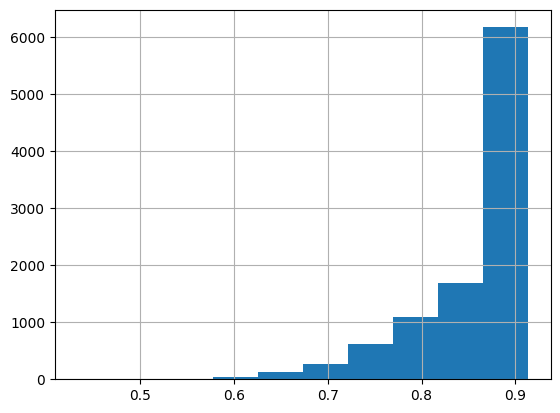

In [10]:
simulations = 10000
prisks = np.repeat(0.0, simulations)
insurer_capital = np.repeat(0.0, simulations)
capital_damages = np.repeat(0.0, simulations)
business_disruption = np.repeat(0.0, simulations)
fair_premiums = np.repeat(0.0, simulations)
insurance_adjustments = np.repeat(0.0, simulations)
npvs = np.repeat(0.0, simulations)

for i in range(simulations):
    asset = PowerPlantSim(
        name=firm["Plant / Project name"],
        flood_damage_curve=continuous_curves,
        flood_exposure=flood_exposure,
        production_path=production_path.copy(),
        replacement_cost=firm["Value"],
    )
    insurer = Insurance("Insurance company", capital=1e9, subscribers=[])
    asset.add_insurer(insurer)
    kernel = Kernel(assets=[asset], insurers=[insurer])
    FloodEntitySim(asset).simulate(time_horizon=TIME_HORIZON, kernel=kernel)
    kernel.run(TIME_HORIZON)
    prisk = max(asset.npv/asset.base_value, 0)
    prisks[i] = prisk
    insurer_capital[i] = insurer.capital
    capital_damages[i] = asset.total_replacement_costs
    business_disruption[i] = asset.total_business_disruption
    fair_premiums[i] = asset.total_fair_insurance_premiums
    insurance_adjustments[i] = asset.total_insurance_adjustments
    npvs[i] = asset.npv

print(f"Mean P-risk: {np.mean(prisks):.2f}")
print(f"Standard deviation: {np.std(prisks):.2f}")
print(f"5th percentile: {np.percentile(prisks, 5):.2f}")
print(f"95th percentile: {np.percentile(prisks, 95):.2f}")
pd.Series(prisks).hist();

In [11]:
import plotly.graph_objects as go

fig = go.Figure(go.Waterfall(
    name = "PRISK - Waterfall", 
    orientation = "v",
    measure = ["relative", "relative", "relative", "relative", "relative", "total"],
    x = ["Base Value", "Capital Damagages", "Business disruptions", "Fair insurance premiums",
            "Insurance adjustments", "Adjusted Value"],
    textposition = "outside",
    text = ["{:,.2f}M".format(asset.base_value/1e6), 
            "{:,.2f}M".format(-capital_damages.mean()/1e6), 
            "{:,.2f}M".format(-business_disruption.mean()/1e6), 
            "{:,.2f}M".format(-fair_premiums.mean()/1e6),
            "{:,.2f}M".format(-insurance_adjustments.mean()/1e6),
            "{:,.2f}M".format(npvs.mean()/1e6)],
    y = [asset.base_value, 
            -capital_damages.mean(),
        -business_disruption.mean(),
        -fair_premiums.mean(), 
        -insurance_adjustments.mean(),
            npvs.mean()],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "PRISK - Waterfall chart",
        showlegend = False,
        template="simple_white",
        margin=dict(l=20, r=20, t=40, b=20),
        xaxis_title="Asset value impacts",
        yaxis_title="Value",
        yaxis_tickprefix="$",
        yaxis_tickformat=",",
        yaxis_showgrid=True,
)

fig.show()